In [69]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from tqdm.notebook import tqdm

In [70]:
torch.cuda.is_available = lambda : False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [91]:
data_dir = os.path.join("D:\SPRING 2023\MS_Thesis\MASTER'S THESIS\Thesis results\DeepCrack-master\codes\data\CRACKTREE260\crack_train_mask_512x512")
train_dir = os.path.join(data_dir, "train") 
val_dir = os.path.join(data_dir, "val")
train_fns = os.listdir(train_dir)
val_fns = os.listdir(val_dir)
print(len(train_fns), len(val_fns))

46 9


## Analyze Data

D:\SPRING 2023\MS_Thesis\MASTER'S THESIS\Thesis results\DeepCrack-master\codes\data\CRACKTREE260\crack_train_mask_512x512\train\crack_train_mask-10009.png


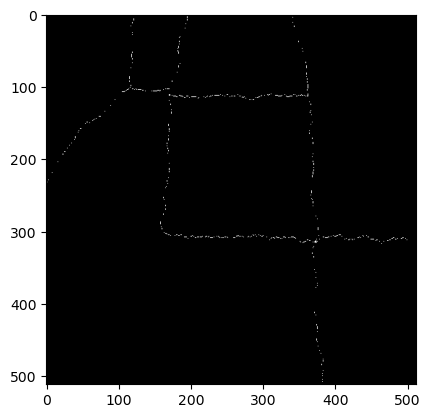

In [92]:
sample_image_fp = os.path.join(train_dir, train_fns[0])
sample_image = Image.open(sample_image_fp).convert("RGB")
plt.imshow(sample_image)
print(sample_image_fp)

In [93]:
def split_image(image):
    image = np.array(image)
    cityscape, label = image[:, :256, :], image[:, 256:, :]
    return cityscape, label

(512, 512, 3)
0 255 0 255


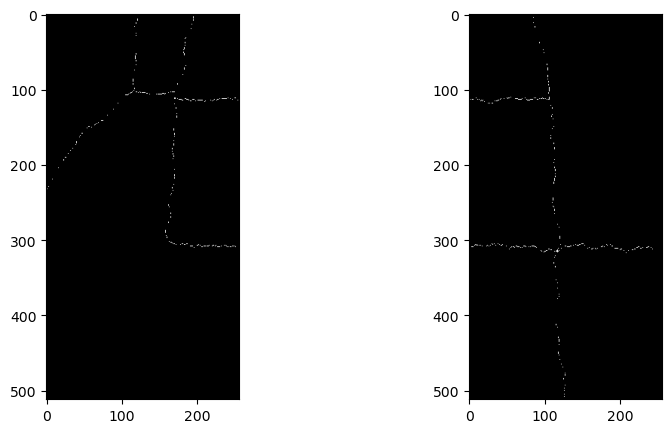

In [94]:
sample_image = np.array(sample_image)
print(sample_image.shape)
cityscape, label = split_image(sample_image)
print(cityscape.min(), cityscape.max(), label.min(), label.max())
cityscape, label = Image.fromarray(cityscape), Image.fromarray(label)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(cityscape)
axes[1].imshow(label)

In [95]:
"""
color_set = set()
for train_fn in tqdm(train_fns[:10]):
    train_fp = os.path.join(train_dir, train_fn)
    image = np.array(Image.open(train_fp))
    cityscape, label = split_image(sample_image)
    label = label.reshape(-1, 3)
    local_color_set = set([tuple(c) for c in list(label)])
    color_set.update(local_color_set)
color_array = np.array(list(color_set))
"""

num_items = 1000
color_array = np.random.choice(range(256), 3*num_items).reshape(-1, 3)
print(color_array.shape)
print(color_array[:5, :])

(1000, 3)
[[ 44  54  34]
 [109  40 217]
 [247 233  73]
 [126 204 216]
 [197  17 249]]


In [96]:
num_classes = 2
label_model = KMeans(n_clusters=num_classes)
label_model.fit(color_array)

C:\Users\tamim\anaconda3\envs\DeepCrack\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

In [97]:
label_model.predict(color_array[:5, :])

array([1, 1, 0, 0, 0])

In [98]:
class Dataset(Dataset):
    
    def __init__(self, image_dir, label_model):
        self.image_dir = image_dir
        self.image_fns = os.listdir(image_dir)
        self.label_model = label_model
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.image_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = np.array(image)
        data, label = self.split_image(image) ## Tamim: changed the name from cityscape to data
        label_class = self.label_model.predict(label.reshape(-1, 3)).reshape(224, 224)
        data = self.transform(data) ## Tamim: changed the name from cityscape to data
        label_class = torch.Tensor(label_class).long()
        return data, label_class ## Tamim: changed the name from  cityscape to data
    
    def split_image(self, image):
        image = np.array(image)
        data, label = image[:, :256, :], image[:, 256:, :] ## Tamim: changed the name from cityscape to data
        return data, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [99]:
dataset = Dataset(train_dir, label_model)
print(len(dataset))

46


In [100]:
data, label_class = dataset[0] ## Tamim: changed the name from cityscape to data
print(data.shape, label_class.shape) ## Tamim: changed the name from cityscape to data

ValueError: cannot reshape array of size 131072 into shape (512,512)